This notebook will collect waveform data and format them into a seisbench compatible hdf5 format in order to disseminate the data sets.


by Marine Denolle (mdenolle@uw.edu)

References:
-  https://github.com/niyiyu/PNW-ML/blob/main/scripts/mpi_extract_comcat_acceleration.py



In [33]:
import os
import logging
from obspy.clients.fdsn import Client
import numpy as np
import obspy
from obspy import Stream
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import pandas as pd
import h5py
from tqdm import tqdm
from itertools import islice
import random
# from pnwstore.mseed import WaveformClient

In [34]:

# Define clients
client_iris = Client('IRIS')
# client_waveform = WaveformClient()
client_ncedc = Client('NCEDC')


## Load the data frame of picks

In [58]:
assoc_df = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/arrival_assoc_origin_2010_2015_reloc_cog_ver3.csv', index_col=0)
assoc_df.head()

,sta,pick_time,arid,iphase,prob,orid,phase,timeres,slatitude,slongitude,...,lon,depth,otime,nass,p_picks,s_picks,rms,nsphz,gap,algorithm
0,UW.PCMD,1.262305e+09,0,P,0.68,0,P,0.049,46.888962,-122.301483,...,-122.16895,56.111,1.262305e+09,7,2,5,1.081,5.0,235.831208,genie
1,UW.RVW,1.262305e+09,1,P,0.68,0,P,1.264,46.149750,-122.742996,...,-122.16895,56.111,1.262305e+09,7,2,5,1.081,5.0,235.831208,genie
2,UW.PCMD,1.262305e+09,2,S,0.68,0,S,-0.243,46.888962,-122.301483,...,-122.16895,56.111,1.262305e+09,7,2,5,1.081,5.0,235.831208,genie
3,UW.GNW,1.262305e+09,3,S,0.68,0,S,2.402,47.564130,-122.824980,...,-122.16895,56.111,1.262305e+09,7,2,5,1.081,5.0,235.831208,genie
4,PB.B013,1.262305e+09,4,S,0.68,0,S,-0.651,47.813000,-122.910797,...,-122.16895,56.111,1.262305e+09,7,2,5,1.081,5.0,235.831208,genie


## Display basic information about the dataset


In [69]:

# Display basic information about the dataset
print(f"Number of records: {len(assoc_df)}")
print("First few rows:")
print(assoc_df.head())
print("Columns:", assoc_df.columns.tolist())

# Assuming the epoch time column is named 'time' - adjust if needed
time_column = 'time'  # Change this if your column has a different name
if time_column in assoc_df.columns:
    # Convert epoch time to datetime
    assoc_df['datetime'] = pd.to_datetime(assoc_df[time_column], unit='s')
    
    # Create a function to convert to UTCDateTime when needed
    def to_utc_datetime(dt):
        return obspy.UTCDateTime(dt)
    
    # Example conversion
    print("\nExample time conversion:")
    example = assoc_df.iloc[0]
    print(f"Epoch: {example[time_column]}")
    print(f"Datetime: {example['datetime']}")
    print(f"UTCDateTime: {to_utc_datetime(example['datetime'])}")

# # Extract unique station information
station_col = 'sta'  # Change if needed
# network_col = 'network'  # Change if needed

if station_col in assoc_df.columns:
    station_list = assoc_df[[station_col]].drop_duplicates().reset_index(drop=True)
    print(f"\nFound {len(station_list)} unique stations:")
    print(station_list.head(10))

Number of records: 1004335
First few rows:
   arid  orid      sta phase  prob  timeres  slatitude  slongitude  \
0     0     0  UW.PCMD     P  0.68    0.049  46.888962 -122.301483   
1     1     0   UW.RVW     P  0.68    1.264  46.149750 -122.742996   
2     2     0  UW.PCMD     S  0.68   -0.243  46.888962 -122.301483   
3     3     0   UW.GNW     S  0.68    2.402  47.564130 -122.824980   
4     4     0  PB.B013     S  0.68   -0.651  47.813000 -122.910797   

   selevation       delta        esaz        seaz          time iphase  \
0       239.0   38.726602  195.021971   15.021971  1.262305e+09      P   
1       504.0  127.374667  199.958459   19.958459  1.262305e+09      P   
2       239.0   38.726602  195.021971   15.021971  1.262305e+09      S   
3       220.0   62.222486  307.013042  127.013042  1.262305e+09      S   
4        75.3   85.968984  319.190764  139.190764  1.262305e+09      S   

                       datetime  
0 2010-01-01 00:15:27.180000000  
1 2010-01-01 00:15:37.8

In [ ]:
# # === CONFIGURATION ===
# client = Client("IRIS")
# network = "UW"
# station = "LON"
# location = "*"
# channel = "BH?"  # 3-component broadband
# starttime = obspy.UTCDateTime("2021-07-04T07:15:00")
# endtime = obspy.UTCDateTime("2021-07-04T07:20:00")

# sta = client_iris.get_stations(network=network, station=station,location="*",channel="*", \
#                                    starttime=starttime , endtime=endtime)
# print(sta)

Inventory created at 2025-06-17T17:13:18.687200Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2021-07-04...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			UW
		Stations (1):
			UW.LON (Longmire, WA, USA)
		Channels (0):



In [ ]:
for (event_id, network, station), group in df.groupby(['event_id', 'network', 'station']):
    # Your processing code here

## Make the hdf5 file and metadata 


In [ ]:
# Initiate module logger
Logger = logging.getLogger(__name__)

# Define the output file names for the waveform data and metadata
output_waveform_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_test.h5"
output_metadata_file_HH_BH = "/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH_test.csv"

output_waveform_file_EH = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_test.h5"
output_metadata_file_EH = "/wd1/hbito_data/data/datasets_all_regions/metadata_EH_test.csv"

# Extract network and station from sta column
df = assoc_df.copy()
df[['network', 'station']] = df['sta'].str.split('.', expand=True)

# Set constants
sampling_rate = 100  # Hz
pre_arrival_time = 50  # time before the first arrival in seconds
window_length = 150  # time window length in seconds

# Create a unique event ID for each unique time
# This assumes different events have different timestamps
df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')

# Create 10 buckets the hdf5 file
waveform_buckets_HH_BH = {str(i): [] for i in range(11)}  # 0 to 10
waveform_buckets_EH = {str(i): [] for i in range(11)}  # 0 to 10

# Group by event_id, network and station to combine P and S arrivals
rows_HH_BH = []
rows_EH = []

group_iter = df.groupby(['event_id', 'network', 'station'])
for (event_id, network, station), group in islice(group_iter, 40):
    # Find P and S arrivals
    p_arrival = group[group['iphase'] == 'P']
    s_arrival = group[group['iphase'] == 'S']
    if s_arrival.empty:
        print(f"No S arrival for event {event_id} at station {station}")
        
    
    # Calculate trace start time (50 seconds before the first arrival)
    first_arrival = group['otime'].min()
    trace_start = first_arrival - pre_arrival_time  # 50 seconds before the first arrival
    trace_end = trace_start + window_length  # 100 seconds after the first arrival

    # Convert to UTCDateTime
#     trace_start1 = obspy.UTCDateTime(trace_start).strftime('%Y-%m-%dT%H:%M:%S')
#     trace_end1 = obspy.UTCDateTime(trace_end).strftime('%Y-%m-%dT%H:%M:%S')
    ##################################################
    otime = obspy.UTCDateTime(first_arrival)
    trace_start1 = obspy.UTCDateTime(trace_start)
    trace_end1 = obspy.UTCDateTime(trace_end)
    ##################################################
    print(f"Trace start: {trace_start1}, Trace end: {trace_end1}")

    # download the waveform data
    try: 
        sta = client_iris.get_stations(network=network, station=station,location="*",channel="*", \
                                    starttime=trace_start1 , endtime=trace_end1)
    except Exception as e:
        print("Error during download or processing:", e)

    try:
        _waveform = client_iris.get_waveforms(network=network, station=station, location='*',channel= '*',\
                                            starttime=trace_start1 , endtime= trace_end1)
        # Detrend
        _waveform.detrend()
        # Resample the waveform traces to 100 Hz
        _waveform.resample(100)
        # Interpolate missing data
        _waveform.merge(method=1,fill_value='interpolate')

    except Exception as e:
        print("Error during download or processing:", e)
    
    # Store the origin data 
    olat = group['lat'].iloc[0]
    olon = group['lon'].iloc[0]
    odepth = group['depth'].iloc[0]*1000

    # Store the station metadata
    slat = sta[0][0].latitude 
    slon = sta[0][0].longitude
    selev = sta[0][0].elevation

    # Create a new stream
    waveform = Stream()

    # Check if loaded data have a vertical component (minimum requirement)
    has_Z = bool(_waveform.select(channel='??Z'))

    # Check for channels presence
    has_HH = bool(_waveform.select(channel="HH?"))
    has_BH = bool(_waveform.select(channel="BH?"))
    has_EH = bool(_waveform.select(channel="EH?"))

    # If no vertical component is present, skip this pick
    if not has_Z:
        Logger.warning('No Vertical Component Data Present. Skipping')
        continue
    
   # Apply selection logic based on channel presence
    if has_HH:
        # If all HH, BH, EH, and EN channels are present, select only HH
        waveform += _waveform.select(channel="HH?")
    elif has_BH:
        # If BH, EH, and EN channels are present, select only BH
        waveform += _waveform.select(channel="BH?")
    elif has_EH:
        # If only EH and EN channels are present, select only EH
        # NTS: This may result in getting only vertical component data - EH? is used for PNSN analog stations
        # NTS: This may also be tricky for pulling full day-volumes because the sampling rate shifts for
        #      analog stations due to the remote digitization scheme used with analog stations
        waveform += _waveform.select(channel="EHZ")
    else:
        continue

    print(f"Number of traces: {len(waveform)}")

    # # Check if the stream have 3-component data
    # if len(waveform) != 3:
    #         continue
    
    # Sort the waveform traces by channel
    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)    


    # Print trace information
    for i, tr in enumerate(waveform):
        
        print(f"Trace {i}: id={tr.id}, tr.stats.channel={tr.stats.channel}, data shape={tr.data.shape}")

    # Sort the waveform traces by channel
    waveform = sorted(waveform, key=lambda tr: tr.stats.channel)

    # Obtain the channel code
    station_channel_code = waveform[0].stats.channel[:-1]

    # Stack the traces into a array
    data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)  # (3, T)
    
    # Determine the shape of the data
    num_trs = data.shape[0]
    num_tps = data.shape[1]
    
    # # save the waveform data to a seisbench format
    # h5_file = f"{network}.{station}..HHZ.{trace_start.strftime('%Y%m%dT%H%M%S')}.h5"
    # waveform.write(h5_file, format='HDF5')

    
    # Calculate P and S samples
    p_sample = None
    if not p_arrival.empty:
        p_time = p_arrival['pick_time'].iloc[0]
        p_sample = int((p_time - trace_start) * sampling_rate)
    
    s_sample = None
    if not s_arrival.empty:
        s_time = s_arrival['pick_time'].iloc[0]
        s_sample = int((s_time - trace_start) * sampling_rate)
    
    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        bucket_HH_BH = str(random.randint(0, 10))
        index_HH_BH = len(waveform_buckets_HH_BH[bucket_HH_BH])
        trace_name = f"{bucket_HH_BH}${index_HH_BH},:{num_trs},:{num_tps}"
        waveform_buckets_HH_BH[bucket_HH_BH].append(data)

    elif has_EH: # IF the waveforms are from EH channels
        bucket_EH = str(random.randint(0, 10))
        print(f"EH bucket: {bucket_EH}")
        index_EH = len(waveform_buckets_EH[bucket_EH])
        trace_name = f"{bucket_EH}${index_EH},:{num_trs},:{num_tps}"
        waveform_buckets_EH[bucket_EH].append(data)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue

    row = {
        'event_id': event_id,
        'source_origin_time': otime,
        'source_latitude_deg': olat,
        'source_longitude_deg': olon,
        'source_type': "earthquake",
        'source_depth_km': odepth,
        'preferred_source_magnitude': None,
        'preferred_source_magnitude_type': None,
        'preferred_source_magnitude_uncertainty': None,
        'source_depth_uncertainty_km': None,
        'source_horizontal_uncertainty_km': None,
        'station_network_code': network,
        'station_channel_code': station_channel_code,
        'station_code': station,
        'station_location_code': "",
        'station_latitude_deg': slat,
        'station_longitude_deg': slon,
        'station_elevation_m': selev,
        'trace_name': trace_name,
        'trace_sampling_rate_hz': sampling_rate,
        'trace_start_time': trace_start1,
        'trace_S_arrival_sample': s_sample,
        'trace_P_arrival_sample': p_sample,
        'trace_S_arrival_uncertainty_s': None,
        'trace_P_arrival_uncertainty_s': None,
        'trace_P_polarity': None,
        'trace_S_onset': "impulsive" if s_sample is not None else None,
        'trace_P_onset': "impulsive" if p_sample is not None else None,
        'trace_snr_db': None,
        'source_type_pnsn_label': None,
        'source_local_magnitude': None,
        'source_local_magnitude_uncertainty': None,
        'source_duration_magnitude': None,
        'source_duration_magnitude_uncertainty': None,
        'source_hand_magnitude': None,
        'trace_missing_channel': "",
        'trace_has_offset': None
    }
        ##################################################


    # Create row
    if has_HH or has_BH: # If the waveforms are from HH or BH channels
        rows_HH_BH.append(row)

    elif has_EH: # IF the waveforms are from EH channels
        rows_EH.append(row)

    else:
        print(f"No valid channel data for event {event_id} at station {station}")
        continue
        
    ##################################################

# Create the seisbench metadata dataframe
seisbench_df_HH_BH = pd.DataFrame(rows_HH_BH)
seisbench_df_EH = pd.DataFrame(rows_EH)

# Display the first few rows
print(f"Created {len(seisbench_df_HH_BH)} metadata entries for HH/BH channels")
print(f"Created {len(seisbench_df_EH)} metadata entries for EH channels")

# === WRITE TO HDF5 ===
print(f"Saving waveform data to {output_waveform_file_HH_BH}...")
with h5py.File(output_waveform_file_HH_BH, "w") as f:
    for bucket, traces in waveform_buckets_HH_BH.items():
        print(f"HH/BH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("HH/BH trace shape:", tr.shape)
            print("HH/BH trace:", tr)
        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("HH/BH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

print(f"Saving waveform data to {output_waveform_file_EH}...")
with h5py.File(output_waveform_file_EH, "w") as f:
    for bucket, traces in waveform_buckets_EH.items():
        print(f"EH bucket: {bucket}, number of traces: {len(traces)}")
        if not traces:
            continue
        for tr in traces:
            print("EH trace shape:", tr.shape)
            print("EH trace:", tr)

        arr = np.stack(traces, axis=0)  # (N, 3, T)
        print("EH arr shape:", arr.shape)
        f.create_dataset(f"/data/{bucket}", data=arr, dtype="float32")

# === WRITE METADATA ===
print(f"Saving metadata to {output_metadata_file_HH_BH}...")
seisbench_df_HH_BH.to_csv(output_metadata_file_HH_BH, index=False)   

print(f"Saving metadata to {output_metadata_file_EH}...")
seisbench_df_EH.to_csv(output_metadata_file_EH, index=False)   

print("Done.")



/tmp/ipykernel_1005566/1817232673.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['event_id'] = 'ev' + df['otime'].astype(str).str.replace('.', '_')


Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Number of traces: 1
Trace 0: id=PB.B013..EHZ, tr.stats.channel=EHZ, data shape=(14999,)
EH bucket: 4
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Number of traces: 1
Trace 0: id=PB.B943..EHZ, tr.stats.channel=EHZ, data shape=(14999,)
EH bucket: 10
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Number of traces: 1
Trace 0: id=UW.BOW..EHZ, tr.stats.channel=EHZ, data shape=(15000,)
EH bucket: 10
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Number of traces: 3
Trace 0: id=UW.GNW..BHE, tr.stats.channel=BHE, data shape=(15000,)
Trace 1: id=UW.GNW..BHN, tr.stats.channel=BHN, data shape=(15000,)
Trace 2: id=UW.GNW..BHZ, tr.stats.channel=BHZ, data shape=(15000,)
Trace start: 2010-01-01T00:14:27.262282Z, Trace end: 2010-01-01T00:16:57.262282Z
Number of traces: 1
Trace 0: id=UW.PCMD..EHZ, tr.stats.channel=EHZ, da

## Verify the test datasets

### Verify the test datasets for HH/BH

Keys in HDF5 file:
 - data
<KeysViewHDF5 ['1', '10', '2', '5', '6', '7', '9']>
 - 1: shape=(1, 3, 14998), min=-1189.58, max=1422.95
 - 10: shape=(3, 3, 14998), min=-18013.44, max=23450.97
 - 2: shape=(1, 3, 14998), min=-31077.54, max=14829.35
 - 5: shape=(1, 3, 14998), min=-14876.95, max=7040.64
 - 6: shape=(1, 3, 14998), min=-23194.01, max=4734.17
 - 7: shape=(1, 3, 14998), min=-1624.50, max=1151.94
 - 9: shape=(2, 3, 14998), min=-5410.42, max=4062.06
samplewaveform shape: (3, 14998)


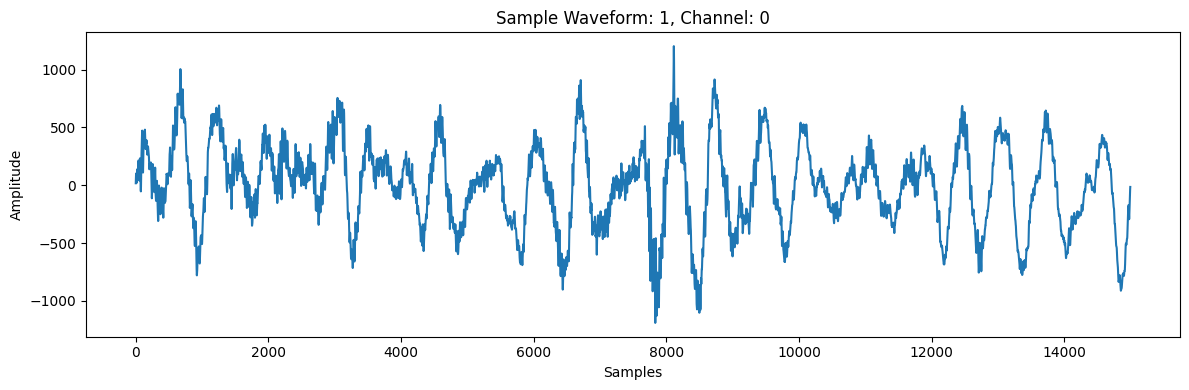

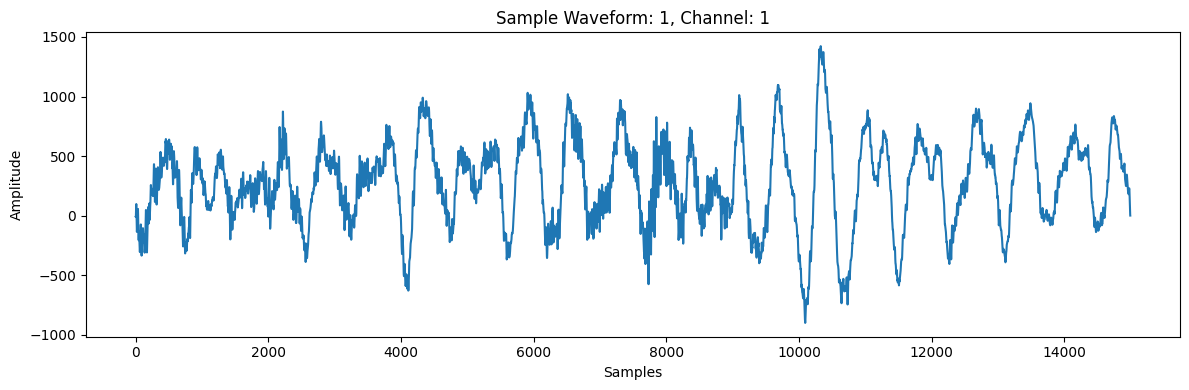

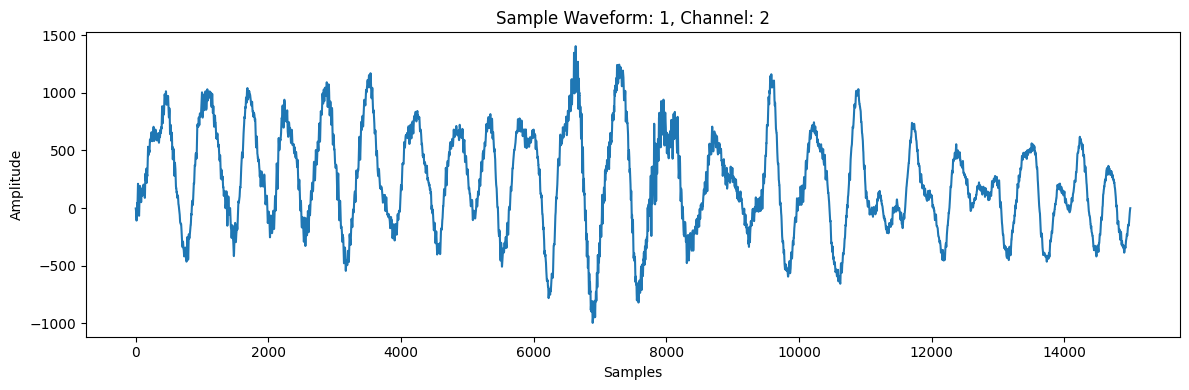

In [144]:
hdf5_test_path = "/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_test.h5"
with h5py.File(hdf5_test_path, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print(f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        sample_key = list(waveforms_group.keys())[0]
        sample_waveform = waveforms_group[sample_key][:]

        print('samplewaveform shape:', sample_waveform[0].shape)

        for i in range(len(sample_waveform[0])):
            plt.figure(figsize=(12, 4))
            y = sample_waveform[0,i,:]
            x = np.arange(len(y))
            plt.plot(x, y)
            plt.title(f"Sample Waveform: {sample_key}, Channel: {i}")
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.tight_layout()
            plt.show()
        

    

In [149]:
test = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/metadata_HH_BH_test.csv')
test.iloc[0:20][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_location_code','station_latitude_deg','station_longitude_deg','station_elevation_m','trace_name','trace_name','trace_sampling_rate_hz', 'trace_start_time','trace_S_arrival_sample','trace_P_arrival_sample','trace_S_onset','trace_P_onset']]

,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_onset,trace_P_onset
0,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,BH,GNW,NaN,47.564130,-122.824980,220.0,"2$0,:3,:14998","2$0,:3,:14998",100,2010-01-01T00:14:27.262282Z,7473,NaN,impulsive,NaN
1,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,BH,HNB,NaN,49.274500,-122.579200,183.0,"9$0,:3,:14998","9$0,:3,:14998",100,2010-01-01T00:15:59.375360Z,8764,7134.0,impulsive,impulsive
2,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,UW,BH,GNW,NaN,47.564130,-122.824980,220.0,"10$0,:3,:14998","10$0,:3,:14998",100,2010-01-01T00:15:59.375360Z,8069,NaN,impulsive,NaN
3,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,UW,BH,PASS,NaN,48.998299,-122.085197,175.4,"1$0,:3,:14998","1$0,:3,:14998",100,2010-01-01T00:15:59.375360Z,7688,6535.0,impulsive,impulsive
4,ev1262330283_689209,2010-01-01T07:18:03.689209Z,47.86208,-122.09903,17799.0,CN,BH,HNB,NaN,49.274500,-122.579200,183.0,"7$0,:3,:14998","7$0,:3,:14998",100,2010-01-01T07:17:13.689209Z,9294,NaN,impulsive,NaN
5,ev1262330283_689209,2010-01-01T07:18:03.689209Z,47.86208,-122.09903,17799.0,UW,BH,GNW,NaN,47.564130,-122.824980,220.0,"5$0,:3,:14998","5$0,:3,:14998",100,2010-01-01T07:17:13.689209Z,6896,NaN,impulsive,NaN
6,ev1262335916_371091,2010-01-01T08:51:56.371091Z,47.96435,-122.91906,21286.0,CN,BH,HNB,NaN,49.274500,-122.579200,183.0,"10$1,:3,:14998","10$1,:3,:14998",100,2010-01-01T08:51:06.371091Z,8908,NaN,impulsive,NaN
7,ev1262362363_83866,2010-01-01T16:12:43.838660Z,45.87262,-122.19180,9822.0,UW,BH,GNW,NaN,47.564130,-122.824980,220.0,"6$0,:3,:14998","6$0,:3,:14998",100,2010-01-01T16:11:53.838660Z,10286,NaN,impulsive,NaN
8,ev1262362363_83866,2010-01-01T16:12:43.838660Z,45.87262,-122.19180,9822.0,UW,BH,YACT,NaN,45.932500,-122.419300,214.0,"9$1,:3,:14998","9$1,:3,:14998",100,2010-01-01T16:11:53.838660Z,5602,5358.0,impulsive,impulsive
9,ev1262369813_218856,2010-01-01T18:16:53.218856Z,48.47626,-123.05830,22641.0,CN,BH,HNB,NaN,49.274500,-122.579200,183.0,"10$2,:3,:14998","10$2,:3,:14998",100,2010-01-01T18:16:03.218856Z,7566,6469.0,impulsive,impulsive


### Verify the test datasets for EH

Keys in HDF5 file:
 - data
f['data'].keys() <KeysViewHDF5 ['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']>
 - 0: shape=(6, 1, 14998), min=-6644.83, max=6889.11
 - 1: shape=(12, 1, 14998), min=-1997.19, max=1682.57
 - 10: shape=(4, 1, 14998), min=-107.72, max=74.69
 - 2: shape=(14, 1, 14998), min=-15931.30, max=6947.44
 - 3: shape=(9, 1, 14998), min=-839.04, max=472.25
 - 4: shape=(7, 1, 14998), min=-668.03, max=429.99
 - 5: shape=(8, 1, 14998), min=-470.06, max=319.50
 - 6: shape=(6, 1, 14998), min=-662.63, max=615.04
 - 7: shape=(10, 1, 14998), min=-1299.27, max=1298.92
 - 8: shape=(7, 1, 14998), min=-76.53, max=124.50
 - 9: shape=(7, 1, 14998), min=-515.13, max=504.70
samplewaveform shape: (1, 14998)


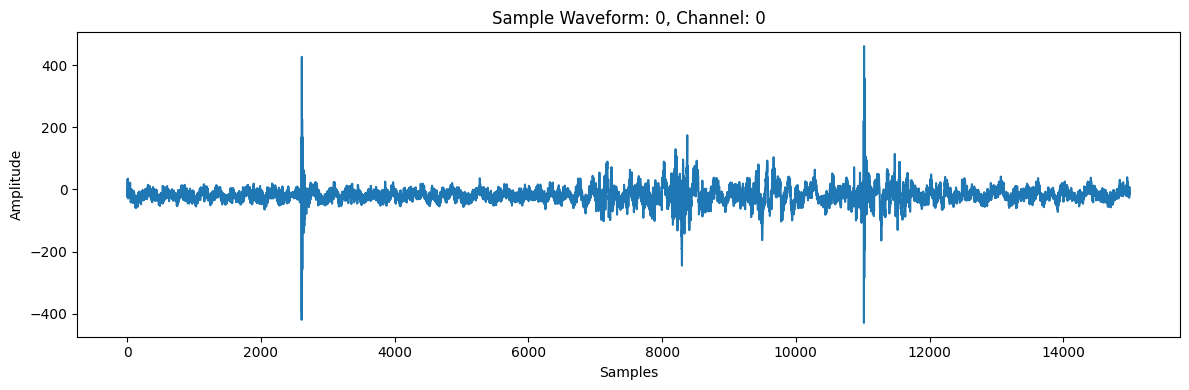

In [145]:
hdf5_test_path = "/wd1/hbito_data/data/datasets_all_regions/waveforms_EH_test.h5"
with h5py.File(hdf5_test_path, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print("f['data'].keys()",f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        sample_key = list(waveforms_group.keys())[0]
        sample_waveform = waveforms_group[sample_key][:]

        print('samplewaveform shape:', sample_waveform[0].shape)

        for i in range(len(sample_waveform[0])):
            plt.figure(figsize=(12, 4))
            y = sample_waveform[0,i,:]
            x = np.arange(len(y))
            plt.plot(x, y)
            plt.title(f"Sample Waveform: {sample_key}, Channel: {i}")
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.tight_layout()
            plt.show()
        


In [148]:
test = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/metadata_EH_test.csv')
test.iloc[0:20][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_location_code','station_latitude_deg','station_longitude_deg','station_elevation_m','trace_name','trace_name','trace_sampling_rate_hz', 'trace_start_time','trace_S_arrival_sample','trace_P_arrival_sample','trace_S_onset','trace_P_onset']]

,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_onset,trace_P_onset
0,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,PB,EH,B013,NaN,47.813000,-122.910797,75.3,"4$0,:1,:14998","4$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,7635.0,NaN,impulsive,NaN
1,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,PB,EH,B943,NaN,47.813202,-122.911301,84.2,"10$0,:1,:14998","10$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,7650.0,NaN,impulsive,NaN
2,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,EH,BOW,NaN,46.474831,-123.229301,870.0,"10$1,:1,:14998","10$1,:1,:14998",100,2010-01-01T00:14:27.262282Z,8079.0,NaN,impulsive,NaN
3,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,EH,PCMD,NaN,46.888962,-122.301483,239.0,"7$0,:1,:14998","7$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,6601.0,5991.0,impulsive,impulsive
4,ev1262304917_262282,2010-01-01T00:15:17.262282Z,47.22533,-122.16895,56111.0,UW,EH,RVW,NaN,46.149750,-122.742996,504.0,"0$0,:1,:14998","0$0,:1,:14998",100,2010-01-01T00:14:27.262282Z,NaN,7057.0,NaN,impulsive
5,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,BIB,NaN,49.410300,-123.310500,38.0,"2$0,:1,:14998","2$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,9863.0,7772.0,impulsive,impulsive
6,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,GOBB,NaN,48.949300,-123.510500,173.0,"9$0,:1,:14998","9$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,9425.0,7508.0,impulsive,impulsive
7,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,VDB,NaN,49.026100,-122.102800,404.0,"1$0,:1,:14998","1$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,NaN,6577.0,NaN,impulsive
8,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,CN,EH,WPB,NaN,49.647800,-123.209400,260.0,"5$0,:1,:14998","5$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,10283.0,8011.0,impulsive,impulsive
9,ev1262305009_37536,2010-01-01T00:16:49.375360Z,48.19518,-121.77276,3820.0,PB,EH,B001,NaN,48.043072,-123.131409,237.0,"3$0,:1,:14998","3$0,:1,:14998",100,2010-01-01T00:15:59.375360Z,8086.0,6763.0,impulsive,impulsive


In [ ]:
# # Verify the saved H5 file
# import h5py
# import pandas as pd
# output_dir = os.path.expanduser('/wd1/hbito_data/data/datasets_all_regions/seisbench_data')
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# # Path to the generated H5 file
# h5_path = os.path.join(output_dir, '/wd1/hbito_data/data/datasets_all_regions/waveforms_HH_BH_test.h5')

# if os.path.exists(h5_path):
#     with h5py.File(h5_path, 'r') as f:
#         # Print basic file information
#         print(f"SeisBench version: {f.attrs.get('seisbench_version')}")
        
#         # List groups
#         print("\nGroups in file:")
#         for group_name in f.keys():
#             print(f" - {group_name}")
        
#         # Print metadata statistics
#         print("\nMetadata statistics:")
#         if 'metadata' in f:
#             metadata_group = f['metadata']
#             for key in metadata_group.keys():
#                 data = metadata_group[key][:]
#                 print(f" - {key}: {len(data)} entries")
                
#             # Convert metadata to DataFrame for viewing
#             metadata_dict = {key: metadata_group[key][:] for key in metadata_group.keys()}
#             metadata_df = pd.DataFrame(metadata_dict)
#             print("\nSample of metadata:")
#             display(metadata_df.head())
        
#         # Print waveform statistics
#         print("\nWaveform statistics:")
#         if 'waveforms' in f:
#             waveforms_group = f['waveforms']
#             print(f" - Number of waveforms: {len(waveforms_group.keys())}")
            
#             # Show information for first few waveforms
#             print("\nSample of waveforms:")
#             for i, key in enumerate(list(waveforms_group.keys())[:5]):
#                 waveform = waveforms_group[key][:]
#                 print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")
                
#             # Plot a sample waveform if matplotlib is available
#             if list(waveforms_group.keys()):
#                 sample_key = list(waveforms_group.keys())[0]
#                 sample_waveform = waveforms_group[sample_key][:]
                
#                 plt.figure(figsize=(12, 4))
#                 plt.plot(sample_waveform)
#                 plt.title(f"Sample Waveform: {sample_key}")
#                 plt.xlabel("Samples")
#                 plt.ylabel("Amplitude")
#                 plt.tight_layout()
#                 plt.show()
# else:
#     print(f"H5 file not found at {h5_path}")
# </VSCode.Cell>

In [ ]:
2010-02-24T12:48:58.323301Z, Trace end: 2010-02-24T12:51:28.323301Z